In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [17]:
plt.style.use('ggplot')

In [18]:
df = pd.read_excel('./multilevel_modeling.xlsx', engine='openpyxl')

In [19]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [20]:
df['id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [21]:
groups = df.groupby(df['id'])

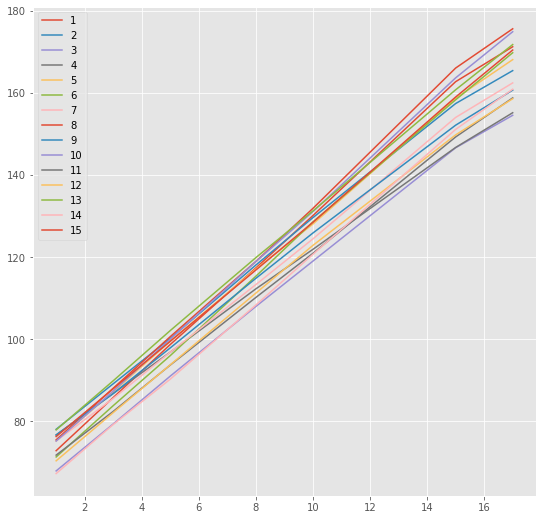

In [22]:
plt.figure(figsize=(9,9))
for name, group in groups:
    plt.plot(group['age'], group['height'], label=name)
plt.legend()

In [27]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1,upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}
"""

In [28]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b2fd66f69ef319504e0b4ac43bf11b1 NOW.
/opt/anaconda3/envs/stan/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/b0/3m9ppxz93zl2xj3hppxlrzbw0000gn/T/tmpskn_yqdu/stanfit4anon_model_3b2fd66f69ef319504e0b4ac43bf11b1_1018638343596274121.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [29]:
stan_data = {'N':df.shape[0], 'N_id':15, 'X':df['age'], 'Y':df['height'], 's_id':df['id']}

In [30]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [31]:
fit

Inference for Stan model: anon_model_3b2fd66f69ef319504e0b4ac43bf11b1.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.4e-3   0.12   5.54   5.69   5.77   5.84   6.01    716    1.0
b0         68.2    0.03   0.93  66.41  67.59  68.17  68.77  70.14    875    1.0
a_id[1]    0.46  4.5e-3   0.13    0.2   0.38   0.47   0.55   0.72    856    1.0
a_id[2]   -0.19  4.6e-3   0.13  -0.47  -0.28  -0.19  -0.11   0.06    825    1.0
a_id[3]   -0.29  4.4e-3   0.13  -0.56  -0.38  -0.29  -0.21  -0.04    871    1.0
a_id[4]    -0.8  4.5e-3   0.13  -1.06  -0.88   -0.8  -0.71  -0.55    845    1.0
a_id[5]    0.09  4.5e-3   0.13  -0.19 4.8e-4   0.09   0.17   0.34    848    1.0
a_id[6]    0.41  4.5e-3   0.13   0.14   0.32   0.41   0.49   0.67    866    1.0
a_id[7]   -0.21  4.4e-3   0.13  -0.48  -0.29  -0.21  -0.12   0.05    877    1.0
a_id[8]    

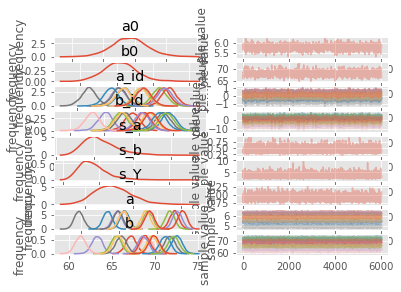

In [32]:
fig = fit.plot()

In [36]:
ms_a = fit.extract('a')['a']
ms_b = fit.extract('b')['b']

In [37]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:,0]

In [38]:
low_Y50, high_Y50 = mstats.mquantiles(df_b, [0.25,0.75], axis=0)
low_Y95, high_Y95 = mstats.mquantiles(df_b, [0.025,0.975], axis=0)

In [39]:
df_0 = groups.get_group(1)

In [40]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


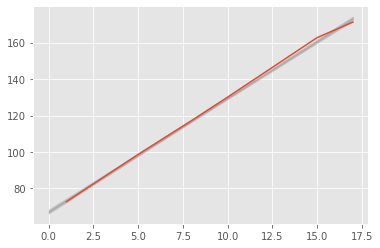

In [41]:
plt.plot(df_0['age'], df_0['height'])
plt.fill_between(x, low_Y50, high_Y50, alpha=0.6, color='darkgray')
plt.fill_between(x, low_Y95, high_Y95, alpha=0.3, color='gray')